## matmul, einsum
- 3차원 이상의 경우 matmul이 최하단 2층에서 매트릭스 곱을 수행
- abc * acb => abb

In [2]:
import torch

In [3]:
from torch import nn

In [4]:
batch_size = 128
seq_len = 30
n_head = 8
head_dim = 64
a = torch.rand(batch_size * seq_len * n_head * head_dim).view(batch_size, seq_len, n_head, head_dim).permute(0, 2, 1, 3)
b = torch.rand(batch_size * seq_len * n_head * head_dim).view(batch_size, seq_len, n_head, head_dim).permute(0, 2, 1, 3).permute(0, 1, 3, 2)

In [5]:
print(a.shape)
print(b.shape)

torch.Size([128, 8, 30, 64])
torch.Size([128, 8, 64, 30])


In [6]:
torch.matmul(a, b).shape

torch.Size([128, 8, 30, 30])

In [19]:
a = torch.rand(batch_size * seq_len * n_head * head_dim).view(batch_size, seq_len, n_head, head_dim)
b = torch.rand(batch_size * seq_len * n_head * head_dim).view(batch_size, seq_len, n_head, head_dim)
a = torch.einsum('blnh->bhln', a)
b = torch.einsum('blnh->bhnl', b)
torch.einsum('bhln,bhnl->bhll', [a, b])

RuntimeError: index l occurs twice in output

In [20]:
a.shape, b.shape

(torch.Size([128, 64, 30, 8]), torch.Size([128, 64, 8, 30]))

In [23]:
a.matmul(b).shape

torch.Size([128, 64, 30, 30])

In [24]:
# b : batch_size
# l : seq_len
# n : n_head
# h : head_dim
torch.einsum('blnh,blnh->bhll', [a, b])

RuntimeError: index l occurs twice in output

## energy = energy.masked_fill(mask == 0, -1e10)
- 레퍼런스 코드의 경우 1차원 어레이로 이루어져 있고, attention map 에서 패딩 컬럼만 제외시킴
- 패딩 로우는 로스에 합쳐지지 않기 때문에 2차원어레이로 마스크 맵을 구성하지 않은듯함.

In [25]:
mock_input = torch.Tensor([[1,2,3,4,5,1,0]])
seq_len = 7
attention_map = torch.rand(seq_len * seq_len).view(seq_len, seq_len)
src_mask = (mock_input != 0).unsqueeze(1)

In [26]:
src_mask

tensor([[[ True,  True,  True,  True,  True,  True, False]]])

In [27]:
attention_map.masked_fill(src_mask ==0, -0.1)

tensor([[[ 0.4565,  0.6401,  0.3613,  0.4663,  0.9962,  0.4703, -0.1000],
         [ 0.0042,  0.8166,  0.5338,  0.4681,  0.1596,  0.4998, -0.1000],
         [ 0.8039,  0.8906,  0.3811,  0.0919,  0.0639,  0.4691, -0.1000],
         [ 0.3579,  0.0065,  0.5442,  0.3238,  0.1018,  0.7051, -0.1000],
         [ 0.7439,  0.2327,  0.3741,  0.8286,  0.1670,  0.7496, -0.1000],
         [ 0.2802,  0.3595,  0.3467,  0.7774,  0.4366,  0.5917, -0.1000],
         [ 0.2785,  0.1373,  0.2052,  0.7237,  0.1813,  0.8650, -0.1000]]])

## contigous
- 중간에 contigous라는 말이 나오는데, numpy array로 구성된 파이토치 텐서의 특성

In [3]:
x = torch.randn(3,2)
y = torch.transpose(x, 0, 1)
x[0, 0] = 42
print(y[0,0]) # 42

tensor(42.)


In [4]:
print("memory ", x.data_ptr())
print("contigious ", x.is_contiguous())
print("stride ", x.stride())
print("offset ", x.storage_offset())
print("stride ", x.storage_type())
print("storage id ", id(x.storage))

memory  94788413959616
contigious  True
stride  (2, 1)
offset  0
stride  <class 'torch.FloatStorage'>
storage id  140200433477584


In [5]:
print("memory ", y.data_ptr())
print("contigious ", y.is_contiguous())
print("stride ", y.stride())
print("offset ", y.storage_offset())
print("stride ", y.storage_type())
print("storage id ", id(y.storage))

memory  94788413959616
contigious  False
stride  (1, 2)
offset  0
stride  <class 'torch.FloatStorage'>
storage id  140198466571952


## positional encoding

In [61]:
# https://simpling.tistory.com/5 참고
import seaborn as sns
def positional_encoding(model_dim, sentence_len):
    print(f"sentence lenght : {sentence_len}, embedding_dim(model_dim) : {model_dim}")
    encoded_vec = []
    for pos in range(sentence_len):
        for i in range(model_dim):
            encoded_vec.append(pos/np.power(10000, 2*i/model_dim))
    encoded_vec = np.array(encoded_vec)

    encoded_vec[::2] = np.sin(encoded_vec[::2])
    encoded_vec[1::2] = np.cos(encoded_vec[1::2])
    return encoded_vec

sentence lenght : 10, embedding_dim(model_dim) : 3


<AxesSubplot:>

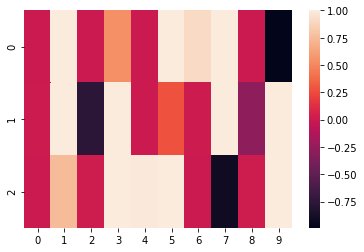

In [117]:
emb_dim,  seq_len = 10, 3
pe_val = positional_encoding(seq_len, emb_dim).reshape(seq_len, emb_dim)
sns.heatmap(pe_val)

sentence lenght : 5, embedding_dim(model_dim) : 3


<AxesSubplot:>

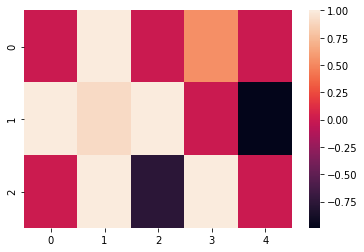

In [118]:
emb_dim,  seq_len = 5, 3
pe_val = positional_encoding(seq_len, emb_dim).reshape(seq_len, emb_dim)
sns.heatmap(pe_val)

## 1-d conv (Positionwise Feed Forward Network)

- embedding dimension은 channel 차원으로 바꿔줘야함
- 2d to 3d (reshape (x, y) -> (x, y, 1)

In [64]:
class ConvPositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.conv1 = nn.Conv1d(hid_dim, pf_dim, kernel_size = 1)
        self.conv2 = nn.Conv1d(pf_dim, hid_dim, kernel_size = 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.conv1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.conv2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [65]:
conv = ConvPositionwiseFeedforwardLayer(3, 5, 0.1)

In [84]:
t1 = torch.rand(9).view(3, 3)

In [87]:
print("original (seq_len * emb_dim)")
print(t1)

original (seq_len * emb_dim)
tensor([[0.0738, 0.2105, 0.8029],
        [0.8034, 0.1473, 0.3732],
        [0.2437, 0.5748, 0.1732]])


In [95]:
print("reshape (emb_dim to channel)")
print(t1.reshape(3,3,1))

reshape (emb_dim to channel)
tensor([[[0.0738],
         [0.2105],
         [0.8029]],

        [[0.8034],
         [0.1473],
         [0.3732]],

        [[0.2437],
         [0.5748],
         [0.1732]]])


In [99]:
for i in conv.conv1.parameters():
    print(i.data)

conv.conv1(t1.reshape(3,3,1))

tensor([[[ 0.0412],
         [-0.2712],
         [ 0.2214]],

        [[-0.4811],
         [-0.2835],
         [ 0.1995]],

        [[-0.2762],
         [-0.3911],
         [ 0.3483]],

        [[-0.1250],
         [ 0.4344],
         [ 0.4743]],

        [[-0.5180],
         [ 0.0111],
         [ 0.0814]]])
tensor([-0.2102, -0.2123,  0.5191, -0.5703,  0.4969])


tensor([[[-0.0865],
         [-0.1473],
         [ 0.6961],
         [-0.1072],
         [ 0.5264]],

        [[-0.1344],
         [-0.5661],
         [ 0.3697],
         [-0.4297],
         [ 0.1127]],

        [[-0.3177],
         [-0.4579],
         [ 0.2874],
         [-0.2689],
         [ 0.3911]]], grad_fn=<SqueezeBackward1>)

In [100]:
(0.0412*0.0738) +  (-0.2712 + 0.2105) + (0.2214 * 0.8029) + -0.2102

-0.09009738